# Introdução

Neste trabalho, feito para disciplina Introdução a Computação Visual ministrada pelo professor William Robson Schwartz, foram implementados compressores de imagem utilizando diferentes técnicas de redundância.

Alunos participantes do trabalho:
- Lucas Junqueira Carvalhido - 2022043264
- Felipe Gomide -
- Leonardo - 

Redundâncias implementadas para compressão de imagens:
- Redundância de Codificação
    - Codificação de Huffman
- Redundância Inter-Pixel
    - Preditor
    - Transformada Discreta de Cosseno (DCT)
    - Transformada de Fourier (DFT)
- Redundância Psico-Visual
    - Quantização

# Bibliotecas

In [128]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pickle
import os
import heapq
from collections import Counter

# Métricas de Erro

In [129]:
# Root Mean Square Error
def rmse_metric(img1, img2):
    return np.sqrt(np.mean((img1.astype("float") - img2.astype("float")) ** 2))

# Coleta das Imagens de Teste

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Pichau\AppData\Local\Temp\ipykernel_1524\480356306.py:2: SyntaxWarning: invalid escape sequence '\p'
  imagem = cv2.imread('images\pgm_bin\marcie.pgm', cv2.IMREAD_GRAYSCALE)


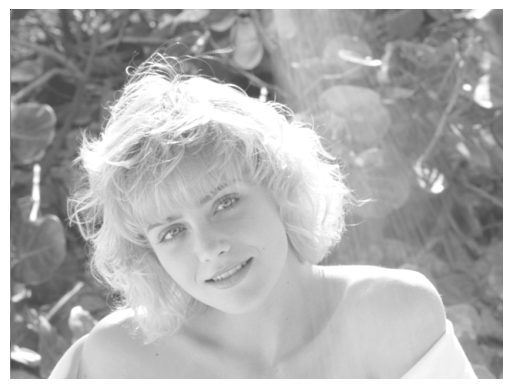

In [130]:
# Carregar a imagem em modo grayscale
imagem = cv2.imread('images\pgm_bin\marcie.pgm', cv2.IMREAD_GRAYSCALE)

# Exibindo imagem
plt.imshow(imagem, cmap='gray')
plt.axis('off') 
plt.show()

In [131]:
# Shape da Imagem
imagem.shape

(480, 640)

# Implementação JPEG 

Neste parte do trabalho será implementada a compressão JPEG de dois modos distintos para fins de comparação. No primeiro modo, será implementada a compressão JPEG classica, seguindo os seguintes passos:

- Compressão:
    1. Imagem subdividida em blocos de 8x8 pixels.
    2. Transformada DCT.
    3. Quantização com uma matriz de quantização pré-definida.
    4. Ordenação Zigue-Zague
    5. Codificação de Huffman

- Descompressão:
    1. Decodificação de Huffman
    2. Desquantização
    3. Transformada inversa DCT (IDCT)

No segundo modo, será implementada a compressão utilizando a transformada de Fourier (DFT) ao invés da Transformada Discreta do Cosseno (DCT), seguindo os seguintes passos:

- Compressão:
    1. Imagem subdividida em blocos de 8x8 pixels.
    2. Transformada DFT.
    3. Quantização com uma matriz de quantização pré-definida.
    4. Codificação de Huffman

- Descompressão:
    1. Decodificação de Huffman
    2. Desquantização
    3. Transformada inversa DFT (IDFT)

Depois, com a realização de testes, se poderá visualizar na prática qual das duas transformadas é mais eficiente na prática de compressão de imagens.

## Implementação da transformada DCT e da transformada inversa IDCT

Esta etapa realiza a **Transformada Discreta do Cosseno (DCT)** e sua inversa (**IDCT**) em uma imagem em escala de cinza, utilizando blocos de `8x8`, e avalia a qualidade da reconstrução utilizando as métricas **RMSE** e **PSNR**.

---

- Funções

  - `dct_transform(img, step=8)`
  Aplica a DCT em blocos de `step x step` (padrão `8x8`) da imagem.

    - **Parâmetros:**
      - `img`: imagem de entrada (matriz 2D).
      - `step`: tamanho do bloco (padrão: 8).
    - **Retorna:** matriz com os coeficientes DCT da imagem.

  - `idct_transform(dct_coefs, step=8)`
  Aplica a **transformada inversa DCT (IDCT)** para reconstruir a imagem a partir dos coeficientes DCT.

    - **Parâmetros:**
      - `dct_coefs`: matriz com os coeficientes DCT.
      - `step`: tamanho do bloco (padrão: 8).
    - **Retorna:** imagem reconstruída.

---

- Processamento

  1. **Pré-processamento da Imagem:**
    - Cópia da imagem original.
    - Conversão para `float`.
    - Deslocamento dos valores de pixel (`img - 128`) para centralizar em torno de zero.

  2. **Aplicação da DCT e IDCT:**
    - A DCT é aplicada usando `cv2.dct()` bloco a bloco.
    - A imagem é reconstruída com `cv2.idct()`.
    - Após a IDCT, desfaz-se o deslocamento adicionando 128.

---

- Visualização

  Exibe 3 imagens lado a lado:
    1. **Imagem Original**
    2. **Imagem Reconstruída**
    3. **Coeficientes DCT** (com escala logarítmica para melhor visualização)

---

- Avaliação

    Duas métricas quantitativas são calculadas para medir a diferença entre a imagem original e a reconstruída:

    1. RMSE `(rmse_metric(img, IDFT_REAL))`: Erro quadrático médio.
    2. PSNR `(cv2.PSNR(img, IDFT_REAL))`: Relação sinal-ruído de pico (em dB).


In [132]:
# Função que realiza a transformada DCT
def dct_transform(img, step=8):

    size = img.shape                    # Shape da imagem
    DCT = np.zeros(size, dtype=float)   # Cria uma matriz para armazenar os coeficientes DCT

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8
            
            dct = cv2.dct(img[y:y+step, x:x+step])   # Aplica DCT no bloco 8x8

            DCT[y:y+step, x:x+step] = dct     # Salva o bloco DCT

    return DCT

# Função que realiza a inversa da DCT (IDCT)
def idct_transform(dct_coefs, step=8):

    size = dct_coefs.shape
    IDCT = np.zeros(size, dtype=float)  # Cria uma matriz para armazenar a imagem reconstruída

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8
            
            idct = cv2.idct(dct_coefs[y:y+step, x:x+step]) # Aplica IDCT 2D no bloco 8x8

            IDCT[y:y+step, x:x+step] = idct   # Salva o bloco reconstruído
    
    IDCT = IDCT + 128 # Desfaz o deslocamento de 128

    return IDCT

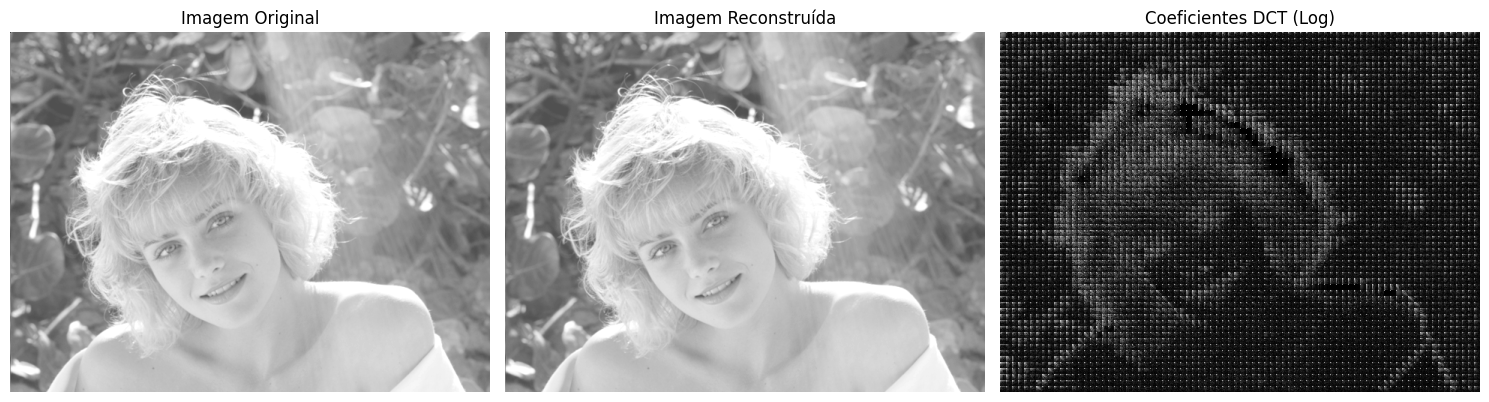

In [133]:
# Input
img = imagem.copy()
img = img.astype(float)             
img = img - 128                     # Centraliza os valores da imagem em torno de 0
step = 8                            # Define o tamanho do bloco (8x8)

# Realiza Transformada
DCT = dct_transform(img, step)

# Realiza a Transformada Inversa
IDCT = idct_transform(DCT, step)

# Desfaz o deslocamento de 128 da imagem
img = img + 128  

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Reconstruída
plt.subplot(1, 3, 2)
plt.imshow(IDCT, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Reconstruída')
plt.axis('off')

# Coeficientes DCT
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(DCT) + 1), cmap='gray')
plt.title('Coeficientes DCT (Log)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [134]:
# Métricas de Erro
rmse = rmse_metric(img, IDCT)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, IDCT)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 1.9825818866017183e-14
Métrica PSNR: 322.089441687731 dB


## Implementação da transformada DFT e da transformada inversa IDFT

Nesta etapa é aplicado a **Transformada Discreta de Fourier (DFT)** em blocos `8x8` de uma imagem em escala de cinza, reconstruindo-a em seguida com a **IDFT**, e avaliando a qualidade da reconstrução com as métricas **RMSE** e **PSNR**.

---

- Funções

    - `dft_transform(img, step=8)`
    Aplica a DFT 2D em blocos `step x step` da imagem.

        - **Parâmetros:**
        - `img`: imagem de entrada (matriz 2D).
        - `step`: tamanho do bloco (padrão: 8).
        - **Retorna:**
        - `DFT_REAL`: parte real dos coeficientes DFT.
        - `DFT_IM`: parte imaginária dos coeficientes DFT.
        - `dft_magnitude`: magnitude dos coeficientes, usada para visualização.

    - `idft_transform(dft_coefs_real, dft_coefs_im, step=8)`
    Aplica a **transformada inversa (IDFT)** para reconstruir a imagem a partir dos coeficientes reais e imaginários da DFT.

        - **Parâmetros:**
        - `dft_coefs_real`: matriz com os coeficientes reais da DFT.
        - `dft_coefs_im`: matriz com os coeficientes imaginários da DFT.
        - `step`: tamanho do bloco (padrão: 8).
        - **Retorna:**
        - `IDFT_REAL`: parte real da imagem reconstruída.
        - `IDFT_IM`: parte imaginária (residual) da imagem reconstruída.
        - `idft_magnitude`: magnitude da reconstrução (não usada diretamente na visualização).

---

- Processamento

    1. **Pré-processamento da Imagem:**
    - A imagem é copiada, convertida para `float`, e centralizada (`img - 128`) para facilitar a aplicação da DFT.

    2. **Transformada de Fourier (DFT):**
    - Cada bloco `8x8` da imagem recebe `cv2.dft()` com `DFT_COMPLEX_OUTPUT`, retornando coeficientes reais e imaginários.
    - A magnitude dos coeficientes é computada com `cv2.magnitude()` e transformada em escala logarítmica para visualização.

    3. **Transformada Inversa (IDFT):**
    - Os coeficientes reais e imaginários são recombinados com `cv2.merge()`.
    - A IDFT é aplicada com `cv2.idft()` e escalonada com `DFT_SCALE`.
    - O deslocamento de 128 é restaurado.

---

- Visualização

    Três imagens são exibidas lado a lado:

    1. **Imagem Original**
    2. **Imagem Reconstruída após IDFT**
    3. **Magnitude da DFT (com escala logarítmica)**

---

- Avaliação

    Duas métricas quantitativas são calculadas para medir a diferença entre a imagem original e a reconstruída:

    1. RMSE `(rmse_metric(img, IDFT_REAL))`: Erro quadrático médio.
    2. PSNR `(cv2.PSNR(img, IDFT_REAL))`: Relação sinal-ruído de pico (em dB).


In [135]:
def dft_transform(img, step=8):

    size = img.shape
    DFT_REAL = np.zeros(size, dtype=float)    # Matriz para armazenar coeficientes reais da DFT
    DFT_IM = np.zeros(size, dtype=float)      # Matriz para armazenar coeficientes imaginarios da DFT

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8
            
            # Aplica DFT 2D no bloco 8x8
            dft = cv2.dft(np.float32(img[y:y+step, x:x+step]), flags=cv2.DFT_COMPLEX_OUTPUT)

            DFT_REAL[y:y+step, x:x+step] = dft[:, :, 0]  # Salva o bloco DFT Real
            DFT_IM[y:y+step, x:x+step] = dft[:, :, 1]    # Salva o bloco DFT Imaginario

    # Magnitude da DFT
    dft_magnitude = cv2.magnitude(DFT_REAL, DFT_IM)

    return DFT_REAL, DFT_IM, dft_magnitude

def idft_transform(dft_coefs_real, dft_coefs_im, step=8):

    size = dft_coefs_real.shape
    IDFT_REAL = np.zeros(size, dtype=float)   # Matriz para armazenar coeficientes reais da IDFT
    IDFT_IM = np.zeros(size, dtype=float)     # Matriz para armazenar coeficientes imaginarios da IDFT

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8

            dft = cv2.merge([dft_coefs_real[y:y+step, x:x+step], dft_coefs_im[y:y+step, x:x+step]])    # Junta os coefs reais e imaginários
            idft = cv2.idft(dft, flags=cv2.DFT_SCALE)                               # Aplica IDFT no bloco transformado

            IDFT_REAL[y:y+step, x:x+step] = idft[:, :, 0]     # Salva o bloco IDFT Real
            IDFT_IM[y:y+step, x:x+step] = idft[:, :, 1]     # Salva o bloco Imaginario
    
    # Magnitude da IDFT
    idft_magnitude = cv2.magnitude(IDFT_REAL, IDFT_IM)
    
    # Desfaz o deslocamento de 128
    IDFT_REAL = IDFT_REAL + 128

    return IDFT_REAL, IDFT_IM, idft_magnitude

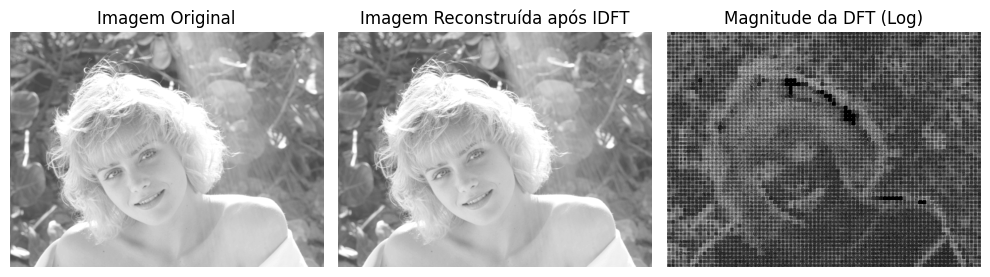

In [136]:
# Input
img = imagem.copy()
img = img.astype(float)             
img = img - 128                     # Centraliza os valores da imagem em torno de 0
step = 8                            # Define o tamanho do bloco (8x8)

# Realiza a transformada DFT
DFT_REAL, DFT_IM, dft_magnitude = dft_transform(img, step)
log_magnitude = np.log(dft_magnitude + 1) # Aplicando log para melhorar a visualização

# Realiza a transformada inversa IDFT
IDFT_REAL, IDFT_IM, idft_magnitude = idft_transform(DFT_REAL, DFT_IM, step)

# Desfaz o deslocamento de 128
img = img + 128

# Visualizar a imagem original e a reconstruída após a IDFT
plt.figure(figsize=(10, 7))

# Imagem original
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')

# Magnitude da DFT
plt.subplot(1, 3, 3)
plt.imshow(log_magnitude, cmap='gray')
plt.title('Magnitude da DFT (Log)')
plt.axis('off')

# Imagem reconstruída após a IDFT
plt.subplot(1, 3, 2)
plt.imshow(IDFT_REAL, cmap='gray')
plt.title('Imagem Reconstruída após IDFT')
plt.axis('off')

plt.tight_layout()
plt.show()

In [137]:
# Métricas de Erro
rmse = rmse_metric(img, IDFT_REAL)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, IDFT_REAL)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 5.443420864684992e-07
Métrica PSNR: 173.41336533274185 dB


## Implementação da função de quantização para a transformada DCT

Nesta etapa são aplicados **quantização** e **desquantização** em blocos da **Transformada Discreta do Cosseno (DCT)** de uma imagem, simulando um processo similar ao da compressão JPEG. Após reconstruir a imagem com a **IDCT**, são calculadas as métricas de qualidade **RMSE** e **PSNR**.

---

- Funções

    - `quantizacao_DCT(DCT, QM, step=8)`
    Aplica a **quantização** dos coeficientes DCT com base em uma matriz de quantização (QM).

        - **Parâmetros:**
        - `DCT`: matriz da transformada DCT da imagem.
        - `QM`: matriz de quantização `8x8` (como a do padrão JPEG).
        - `step`: tamanho dos blocos (padrão: 8).
        - **Retorna:**
        - `quant_coefs`: coeficientes DCT quantizados.
        - `dc_array`: array contendo os coeficientes DC (posição [0,0]) originais de cada bloco.

    - `desquantization_DCT(quant_coefs, dc_array, QM, useDC=True, step=8)`
    Desfaz o processo de quantização, restaurando os coeficientes DCT aproximados.

        - **Parâmetros:**
        - `quant_coefs`: coeficientes quantizados.
        - `dc_array`: lista com os coeficientes DC originais (opcionalmente utilizados).
        - `QM`: matriz de quantização.
        - `useDC`: define se o coeficiente DC original deve ser restaurado (padrão: `True`).
        - `step`: tamanho dos blocos.
        - **Retorna:**
        - `original_coefs`: matriz com os coeficientes DCT restaurados.

---

- Processamento

    1. **Pré-processamento da Imagem:**
    - A imagem é convertida para `float` e centralizada com `img - 128`.

    2. **Matriz de Quantização:**
    - Uma matriz padrão JPEG `8x8` é usada, contendo valores maiores para frequências mais altas (favorecendo compressão).

    3. **Transformada DCT:**
    - Aplicada em blocos `8x8` com a função `dct_transform()` (supondo definida anteriormente).

    4. **Quantização:**
    - Cada bloco DCT é dividido pela matriz de quantização e arredondado.
    - O coeficiente DC original é armazenado separadamente.

    5. **Desquantização:**
    - Os coeficientes quantizados são multiplicados pela matriz de quantização.
    - O coeficiente DC original é reintroduzido se `useDC=True`.

    6. **Transformada Inversa (IDCT):**
    - Os coeficientes desquantizados são transformados de volta ao domínio espacial com `idct_transform()`.

    7. **Pós-processamento:**
    - O valor `128` é somado novamente à imagem reconstruída para desfazer o deslocamento inicial.

---

- Visualização

São exibidas as seguintes imagens lado a lado:

1. **Imagem Original**
2. **Imagem Reconstruída após Quantização e IDCT**

---

- Avaliação

    Duas métricas quantitativas são calculadas para medir a diferença entre a imagem original e a reconstruída:

    1. RMSE `(rmse_metric(img, IDFT_REAL))`: Erro quadrático médio.
    2. PSNR `(cv2.PSNR(img, IDFT_REAL))`: Relação sinal-ruído de pico (em dB).

In [138]:
def quantizacao_DCT(DCT, QM, step=8):
    
    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    
    size = DCT.shape
    quant_coefs = np.zeros(size, dtype=float) # Matriz para armazenar os coeficientes quantizados
    dc_array = []                             # Array para armazenar os coeficientes DC originais
    
    for y in range(0,size[0],step):
        for x in range(0,size[1],step):

            dct = DCT[y:y+step, x:x+step]

            DC = dct[0,0]            # Adquire o coeficiente DC
            dct = np.divide(dct, QM) # Divive a DCT pela matriz de quantização
            dct = dct.round()        # Arredondamento da matriz quantizada

            quant_coefs[y:y+step, x:x+step] = dct # Salva o bloco quantizado
            dc_array.append(DC)
    
    return quant_coefs, dc_array

def desquantization_DCT(quant_coefs, dc_array, QM, useDC=True, step=8):

    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    
    size = quant_coefs.shape
    original_coefs = np.zeros(size, dtype=float)

    for y in range(0,size[0],step):
        for x in range(0,size[1],step):
            # Multiplica a matriz quantizada pela matriz de quantização
            dct = np.multiply(quant_coefs[y:y+step, x:x+step], QM)

            if (useDC == True):
                dct[0,0] = dc_array[0]  # Recupera o coeficiente DC original
                dc_array = dc_array[1:] # Retira o primeiro elemento do array
        
            original_coefs[y:y+step, x:x+step] = dct
    
    return original_coefs

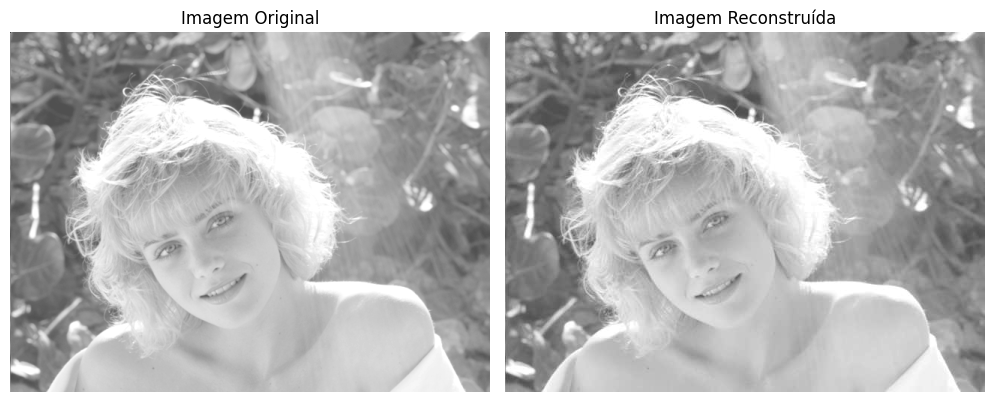

In [139]:
# Input
img = imagem.copy()
img = img.astype(float)             
img = img - 128                     # Centraliza os valores da imagem em torno de 0
step = 8                            # Define o tamanho do bloco (8x8)

# Matriz de Quantização
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

# Realiza Transformada DCT
DCT = dct_transform(img, step)

# Quantização
quant_coefs, dc_array = quantizacao_DCT(DCT, QM)

# Desquantização
original_coefs = desquantization_DCT(quant_coefs, dc_array, QM)

# Realiza a Transformada Inversa
IDCT = idct_transform(original_coefs, step)

# Desfaz o deslocamento de 128 da imagem
img = img + 128  

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Reconstruída
plt.subplot(1, 3, 2)
plt.imshow(IDCT, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Reconstruída')
plt.axis('off')

plt.tight_layout()
plt.show()

In [140]:
# Métricas de Erro
rmse = rmse_metric(img, IDCT)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, IDCT)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 2.7407663258259887
Métrica PSNR: 39.37336341398097 dB


## Implementação da função de quantização para a transformada DFT

Nesta etapa é aplicado um processo de **quantização** sobre a **Transformada Discreta de Fourier (DFT)** de uma imagem, especificamente sobre a **magnitude** dos coeficientes, preservando a **fase**. A imagem é então reconstruída com base na **desquantização** e transformada inversa. Esse processo simula compressão no domínio da frequência com perda controlada.

---

- Funções

    - `quantizacao_DFT(DFT_REAL, DFT_IM, QM, step=8)`
    Aplica quantização na **magnitude** dos coeficientes DFT, bloco a bloco.

        - **Parâmetros:**
        - `DFT_REAL`, `DFT_IM`: partes real e imaginária da DFT da imagem.
        - `QM`: matriz de quantização `8x8` (padrão JPEG).
        - `step`: tamanho dos blocos (padrão: 8).
        - **Processo:**
        - Calcula **magnitude** e **fase** dos coeficientes DFT usando `cv2.magnitude()` e `cv2.phase()`.
        - Divide a magnitude pelo QM e arredonda (quantização).
        - **Retorna:**
        - `magnitude_quant`: magnitude quantizada.
        - `phase`: matriz de fases original (preservada para reconstrução).

    - `desquantizacao_DFT(magnitude_quant, phase, QM, step=8)`
    Reconstrói as partes real e imaginária da DFT com base na magnitude quantizada e fase original.

        - **Parâmetros:**
        - `magnitude_quant`: magnitude quantizada.
        - `phase`: fase original dos coeficientes DFT.
        - `QM`: matriz de quantização.
        - `step`: tamanho dos blocos.
        - **Processo:**
        - Multiplica cada bloco da magnitude quantizada pela QM.
        - Reconstroi partes real e imaginária usando:
            - `real = magnitude × cos(fase)`
            - `imag = magnitude × sin(fase)`
        - **Retorna:**
        - `original_dft_real`, `original_dft_im`: partes real e imaginária da DFT restauradas.

---

- Processamento da Imagem

    1. **Pré-processamento:**
    - Converte imagem para `float` e centraliza os valores com `img - 128`.

    2. **Matriz de Quantização:**
    - Matriz JPEG padrão usada para definir a granularidade da quantização.

    3. **Transformada DFT:**
    - A DFT é aplicada por bloco (8x8), com funções `DFT_REAL`, `DFT_IM`, assumidas como resultado da função `dft_transform()` (não mostrada no código).

    4. **Quantização:**
    - É aplicada apenas à **magnitude** dos coeficientes da DFT.
    - A fase é preservada sem alterações.

    5. **Desquantização:**
    - A magnitude é reescalada.
    - Usando a fase original, são reconstruídos os coeficientes DFT (parte real e imaginária).

    6. **Transformada Inversa (IDFT):**
    - Reverte os coeficientes DFT para o domínio espacial (imagem reconstruída) com `idft_transform()`.

    7. **Pós-processamento:**
    - O deslocamento de 128 é desfeito com `img + 128`.

---

- Visualização

    São exibidas duas imagens:

    1. **Imagem Original**: após o deslocamento reverso.
    2. **Imagem Reconstruída**: a partir da DFT quantizada e desquantizada.

---

- Avaliação

    Duas métricas quantitativas são calculadas para medir a diferença entre a imagem original e a reconstruída:

    1. RMSE `(rmse_metric(img, IDFT_REAL))`: Erro quadrático médio.
    2. PSNR `(cv2.PSNR(img, IDFT_REAL))`: Relação sinal-ruído de pico (em dB).


In [141]:
def quantizacao_DFT(DFT_REAL, DFT_IM, QM, step=8):

    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    
    size = DFT_REAL.shape
    magnitude_quant = np.zeros(size, dtype=float)

    magnitude = cv2.magnitude(DFT_REAL, DFT_IM)
    phase = cv2.phase(DFT_REAL, DFT_IM)

    for y in range(0,size[0],step):
        for x in range(0,size[1],step):

            # Realizando quantização no bloco da matriz de magnitude
            magnitude_bloco = np.divide(magnitude[y:y+step, x:x+step], QM) # Divive pela matriz de quantização
            magnitude_bloco = magnitude_bloco.round()                      # Arredondamento da matriz quantizada

            magnitude_quant[y:y+step, x:x+step] = magnitude_bloco # Salva o bloco quantizado

    return magnitude_quant, phase

def desquantizacao_DFT(magnitude_quant, phase, QM, step=8):

    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    
    size = magnitude_quant.shape
    original_dft_real = np.zeros(size, dtype=float)
    original_dft_im = np.zeros(size, dtype=float)

    for y in range(0,size[0],step):
        for x in range(0,size[1],step):

            # Multiplica a matriz quantizada pela matriz de quantização
            magnitude_bloco = np.multiply(magnitude_quant[y:y+step, x:x+step], QM)

            # Reconstrução da matriz de coeficientes reais
            real_bloco = magnitude_bloco * np.cos(phase[y:y+step, x:x+step])
            im_bloco = magnitude_bloco * np.sin(phase[y:y+step, x:x+step])

        
            original_dft_real[y:y+step, x:x+step] = real_bloco
            original_dft_im[y:y+step, x:x+step] = im_bloco

    return original_dft_real, original_dft_im

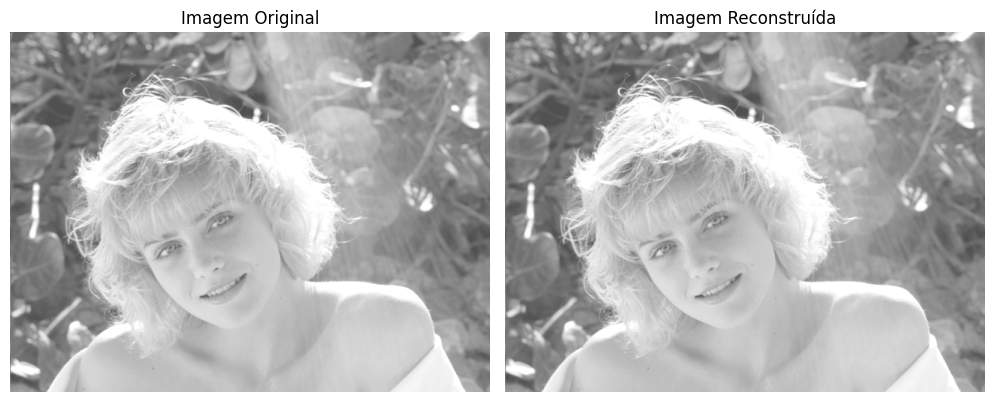

In [142]:
# Input
img = imagem.copy()
img = img.astype(float)             
img = img - 128                     # Centraliza os valores da imagem em torno de 0
step = 8                            # Define o tamanho do bloco (8x8)

# Matriz de Quantização
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

# Realiza Transformada DFT
IDFT_REAL, IDFT_IM, idft_magnitude = idft_transform(DFT_REAL, DFT_IM, step)

# Quantização
magnitude_quant, phase = quantizacao_DFT(DFT_REAL, DFT_IM, QM)

# Desquantização
original_coefs_real, original_coefs_im = desquantizacao_DFT(magnitude_quant, phase, QM)

# Realiza a Transformada Inversa
IDCT_REAL, IDFT_IM, magnitude = idft_transform(original_coefs_real, original_coefs_im)

# Desfaz o deslocamento de 128 da imagem
img = img + 128  

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Reconstruída
plt.subplot(1, 3, 2)
plt.imshow(IDFT_REAL, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Reconstruída')
plt.axis('off')

plt.tight_layout()
plt.show()

In [143]:
# Métricas de Erro
rmse = rmse_metric(img, IDFT_REAL)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, IDFT_REAL)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 5.443420864684992e-07
Métrica PSNR: 173.41336533274185 dB


## Implementação da Codificação Huffman

Ainda falta consertar a parte do codigo relacionado a DFT e fazer a descrição

In [144]:
class NoHuffman:
    def __init__(self, valor=None, freq=0, esq=None, dir=None):
        self.valor = valor
        self.freq = freq
        self.esq = esq
        self.dir = dir
    
    def __lt__(self, outro):  # Necessário para usar o heapq
        return self.freq < outro.freq

def construir_arb_huffman(frequencias):
    # Cria a heap com os nós folha
    heap = [NoHuffman(valor, freq) for valor, freq in frequencias.items()]
    heapq.heapify(heap)

    # Construa a árvore
    while len(heap) > 1:
        no1 = heapq.heappop(heap)
        no2 = heapq.heappop(heap)
        no_novo = NoHuffman(freq=no1.freq + no2.freq, esq=no1, dir=no2)
        heapq.heappush(heap, no_novo)

    return heap[0]  # Retorna a raiz da árvore

def gerar_codigos_huffman(raiz, prefixo="", codigos={}):
    if raiz is None:
        return
    if raiz.valor is not None:
        codigos[raiz.valor] = prefixo
    gerar_codigos_huffman(raiz.esq, prefixo + "0", codigos)
    gerar_codigos_huffman(raiz.dir, prefixo + "1", codigos)
    return codigos

# Função para aplicar a quantização e codificação de Huffman
def huffman_encode(quant_coefs):
    # Flatten a matriz para tratar os coeficientes DCT quantizados
    quant_flat = quant_coefs.flatten()
    
    # Contar a frequência dos coeficientes
    frequencias = Counter(quant_flat)

    # Construir a árvore de Huffman
    raiz = construir_arb_huffman(frequencias)
    
    # Gerar os códigos Huffman
    codigos_huffman = gerar_codigos_huffman(raiz)
    
    # Codificar a imagem (gerar a sequência binária)
    dados_codificados = ''.join([codigos_huffman[p] for p in quant_flat])
    
    return codigos_huffman, dados_codificados

def huffman_decode(dados_comprimidos):
    # Recupera os dados comprimidos e o dicionário de códigos Huffman
    dados_codificados = dados_comprimidos['dados_codificados']
    codigos_huffman = dados_comprimidos['codigos_huffman']
    
    # Inverter o dicionário de códigos Huffman para mapear os prefixos para os valores
    codigos_invertidos = {v: k for k, v in codigos_huffman.items()}
    
    # Variáveis para armazenar os coeficientes quantizados
    quant_coefs_rec = []
    i = 0  # Posição no stream de dados codificados
    
    # Descodificar os dados codificados
    while i < len(dados_codificados):
        # Tenta encontrar o código correspondente no stream de dados
        for tamanho in range(1, len(dados_codificados) - i + 1):
            prefixo = dados_codificados[i:i + tamanho]
            if prefixo in codigos_invertidos:
                # Adiciona o valor correspondente à lista de coeficientes
                quant_coefs_rec.append(codigos_invertidos[prefixo])
                i += tamanho  # Avança a posição no stream
                break
    
    # Converter a lista de coeficientes de volta para a forma matricial
    shape = dados_comprimidos['shape']
    quant_coefs_rec = np.array(quant_coefs_rec).reshape(shape)
    
    return quant_coefs_rec

# def huffman_decode_dft(dados_comprimidos):
#     # Recupera os dados comprimidos e o dicionário de códigos Huffman
#     dados_codificados_mag = dados_comprimidos['dados_codificados_mag']
#     dados_codificados_phase = dados_comprimidos['dados_codificados_phase']
#     codigos_huffman_mag = dados_comprimidos['codigos_huffman_mag']
#     codigos_huffman_phase = dados_comprimidos['codigos_huffman_phase']
    
#     # Inverter o dicionário de códigos Huffman para mapear os prefixos para os valores
#     codigos_invertidos_mag = {v: k for k, v in codigos_huffman_mag.items()}
#     # Variáveis para armazenar os coeficientes quantizados
#     magnitude_rec = []
#     i = 0  # Posição no stream de dados codificados
#     # Descodificar os dados codificados
#     while i < len(dados_codificados_mag):
#         # Tenta encontrar o código correspondente no stream de dados
#         for tamanho in range(1, len(dados_codificados_mag) - i + 1):
#             prefixo = dados_codificados_mag[i:i + tamanho]
#             if prefixo in codigos_invertidos_mag:
#                 # Adiciona o valor correspondente à lista de coeficientes
#                 magnitude_rec.append(codigos_invertidos_mag[prefixo])
#                 i += tamanho  # Avança a posição no stream
#                 break
#     # Converter a lista de coeficientes de volta para a forma matricial
#     shape = dados_comprimidos['shape_mag']
#     magnitude_rec = np.array(magnitude_rec).reshape(shape)

#     # Inverter o dicionário de códigos Huffman para mapear os prefixos para os valores
#     codigos_invertidos_phase = {v: k for k, v in codigos_huffman_phase.items()}
#     # Variáveis para armazenar os coeficientes quantizados
#     phase_rec = []
#     i = 0  # Posição no stream de dados codificados
#     # Descodificar os dados codificados
#     while i < len(dados_codificados_phase):
#         # Tenta encontrar o código correspondente no stream de dados
#         for tamanho in range(1, len(dados_codificados_phase) - i + 1):
#             prefixo = dados_codificados_phase[i:i + tamanho]
#             if prefixo in codigos_invertidos_phase:
#                 # Adiciona o valor correspondente à lista de coeficientes
#                 phase_rec.append(codigos_invertidos_phase[prefixo])
#                 i += tamanho  # Avança a posição no stream
#                 break
#     # Converter a lista de coeficientes de volta para a forma matricial
#     shape = dados_comprimidos['shape_phase']
#     phase_rec = np.array(phase_rec).reshape(shape)
    
#     return magnitude_rec, phase_rec

import numpy as np

def huffman_decode_dft(dados_comprimidos):
    def decode(dados_codificados, codigos_huffman, shape):
        # Inverter o dicionário de códigos Huffman
        codigos_invertidos = {v: k for k, v in codigos_huffman.items()}
        
        # Lista para armazenar os coeficientes
        quant_coefs_rec = []
        i = 0  # Índice no stream de bits
        
        # Decodificação bit a bit
        while i < len(dados_codificados):
            for tamanho in range(1, len(dados_codificados) - i + 1):
                prefixo = dados_codificados[i:i + tamanho]
                if prefixo in codigos_invertidos:
                    quant_coefs_rec.append(codigos_invertidos[prefixo])
                    i += tamanho
                    break
                    
        return np.array(quant_coefs_rec).reshape(shape)
    
    # Decodificar magnitude
    magnitude = decode(
        dados_comprimidos['dados_codificados_mag'],
        dados_comprimidos['codigos_huffman_mag'],
        dados_comprimidos['shape_mag']
    )
    print("OI")
    
    # Decodificar fase
    fase = decode(
        dados_comprimidos['dados_codificados_phase'],
        dados_comprimidos['codigos_huffman_phase'],
        dados_comprimidos['shape_phase']
    )
    
    return magnitude, fase


In [145]:
# Teste da compressão Huffman
img = imagem.copy()
img = img.astype(float)

# Taxa de compressão

## Implementação técnica de Zigue-Zague do JPEG

In [146]:
 # Converte uma matriz 8x8 em uma lista usando o percurso zigue-zague  
def zigzag(block):  
    z = np.empty(64, dtype=block.dtype)
    index = -1
    for i in range(0, 15):
        bound = 0 if i < 8 else i - 7
        for j in range(bound, i - bound + 1):
            if i % 2 == 0:
                x, y = j, i - j
            else:
                x, y = i - j, j
            if x < 8 and y < 8:
                index += 1
                z[index] = block[x][y]
    return z

# Converte uma lista de 64 elementos em uma matriz 8x8 usando percurso zigue-zague inverso
def inverse_zigzag(array):
    block = np.empty((8, 8), dtype=array.dtype)
    index = -1
    for i in range(0, 15):
        bound = 0 if i < 8 else i - 7
        for j in range(bound, i - bound + 1):
            if i % 2 == 0:
                x, y = j, i - j
            else:
                x, y = i - j, j
            if x < 8 and y < 8:
                index += 1
                block[x][y] = array[index]
    return block

## Funções de compressão e descompressão usando a transformada DCT (JPEG clássico)

Nesta etapa do trabalho é simulo o processo de compressão e descompressão de uma imagem em estilo **JPEG**, utilizando:

- **Transformada Discreta do Cosseno (DCT)**
- **Quantização com matriz JPEG padrão**
- **Codificação de Huffman**
- (Opcionalmente) Zig-Zag (ainda não implementado)

---

- Funções

    - `dct_jpeg_compression(img, file_name, step=8)`
    Executa o pipeline completo de compressão JPEG com DCT e salva os dados comprimidos.

        - **Etapas:**

            1. **Pré-processamento da imagem**
            - Converte para `float`.
            - Subtrai 128 para centralizar os valores no intervalo `[-128, 127]`.

            2. **Matriz de Quantização (QM)**
            - Matriz padrão do JPEG utilizada para compressão com perdas.

            3. **Transformada DCT**
            - Calcula a DCT da imagem com `dct_transform()` (assumida como definida em outro trecho).

            4. **Quantização**
            - Aplica quantização bloco a bloco com `quantizacao_DCT()`:
                - Divide os coeficientes DCT pela QM e arredonda.
                - Extrai também os coeficientes DC (média dos blocos), armazenados separadamente.
            
            5. **Ordenação em zigue-zague**
            - Percorre os blocos em zigue-zague conforme a ordem vista em sala

            6. **Codificação de Huffman**
            - Aplica compressão por entropia com `huffman_encode()`.

            7. **Salvamento dos dados comprimidos**
            - Armazena:
                - Dados codificados,
                - Dicionário Huffman,
                - Shape original da matriz,
                - Vetor `dc_array`.
            - Usa `pickle` para salvar o objeto serializado em `'images/compressed/<file_name>'`.


    - `dct_jpeg_descompression(img_path, step=8)`
    Descomprime a imagem a partir de um arquivo `.huff`.

        - **Etapas:**

            1. **Matriz de Quantização**
            - Mesma QM usada na compressão.

            2. **Leitura dos dados comprimidos**
            - Usa `pickle` para carregar:
                - Dados codificados,
                - Tabela de Huffman,
                - `dc_array`,
                - Shape dos dados.

            3. **Decodificação de Huffman**
            - Reconstrói os coeficientes quantizados com `huffman_decode()`.

            4. **Desquantização**
            - Usa `desquantization_DCT()` para multiplicar os coeficientes quantizados pela QM e restaurar os valores aproximados originais.

            5. **Transformada Inversa (IDCT)**
            - Reconstrói a imagem no domínio espacial usando `idct_transform()`.

            6. **Retorna** a imagem reconstruída.

---

- Visualização

    Mostra lado a lado:
    - A imagem original (`img`)
    - A imagem descomprimida (`img_rec`)

---

- Avaliação

    Três métricas quantitativas são calculadas para medir a diferença entre a imagem original e a reconstruída:

    1. RMSE `(rmse_metric(img, IDFT_REAL))`: Erro quadrático médio.
    2. PSNR `(cv2.PSNR(img, IDFT_REAL))`: Relação sinal-ruído de pico (em dB).
    3. Taxa de compressão `Tamanho Original / Tamanho comprimido`


In [147]:
def dct_jpeg_compression(img, file_name, step=8):
    
    img = img.astype(float)             
    img = img - 128                     # Centraliza os valores da imagem em torno de 0

    # Matriz de Quantização
    QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                    [12, 12, 14, 19, 26, 58, 60, 55],
                    [14, 13, 16, 24, 40, 57, 69, 56],
                    [14, 17, 22, 29, 51, 87, 80, 62],
                    [18, 22, 37, 56, 68, 109, 103, 77],
                    [24, 35, 55, 64, 81, 104, 113, 92],
                    [49, 64, 78, 87, 103, 121, 120, 101],
                    [72, 92, 95, 98, 112, 100, 103, 99]])

    # 1. Realiza Transformada DCT
    DCT = dct_transform(img)
    
    # 2. Quantização
    quant_coefs, dc_array = quantizacao_DCT(DCT, QM)
    
    # 3. Oredenação Zigue-Zague (Ainda tem que implementar)
    zigzagged_blocks = np.empty_like(quant_coefs)
    for i in range(0, quant_coefs.shape[0], 8):
        for j in range(0, quant_coefs.shape[1], 8):
            block = quant_coefs[i:i+8, j:j+8]
            zigzagged_blocks[i:i+8, j:j+8] = zigzag(block).reshape((8, 8)) 
    
    # 4. Codificação Huffman (Codificação por Entropia)
    codigos_huffman, dados_codificados = huffman_encode(zigzagged_blocks)

    # Salvando dados comprimidos:
    dados_comprimidos = {
        'dados_codificados': dados_codificados,
        'codigos_huffman': codigos_huffman,
        'shape': quant_coefs.shape,
        'dc_array': dc_array
    }
    path = os.path.join('images/compressed', file_name)
    with open(path, 'wb') as f:
        pickle.dump(dados_comprimidos, f)
    print(f"Dados comprimidos salvos em {path}")

    # Desfaz o deslocamento de 128 da imagem
    img = img + 128


def dct_jpeg_descompression(img_path, step=8):

    # Matriz de Quantização
    QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                    [12, 12, 14, 19, 26, 58, 60, 55],
                    [14, 13, 16, 24, 40, 57, 69, 56],
                    [14, 17, 22, 29, 51, 87, 80, 62],
                    [18, 22, 37, 56, 68, 109, 103, 77],
                    [24, 35, 55, 64, 81, 104, 113, 92],
                    [49, 64, 78, 87, 103, 121, 120, 101],
                    [72, 92, 95, 98, 112, 100, 103, 99]])

    # Carregar os dados comprimidos
    with open(img_path, 'rb') as f:
        dados_comprimidos = pickle.load(f)

    # Coeficientes quantizados e dc_array recuperados
    zigzagged_blocks = huffman_decode(dados_comprimidos)
    dc_array = dados_comprimidos['dc_array']
    shape = dados_comprimidos['shape']

    # Reverter Zigue Zague
    quant_coefs_rec = np.zeros(shape)
    for i in range(0, shape[0], 8):
        for j in range(0, shape[1], 8):
            zigzag_seq = zigzagged_blocks[i:i+8, j:j+8].flatten()
            block = inverse_zigzag(zigzag_seq)
            quant_coefs_rec[i:i+8, j:j+8] = block

    # Desquantização
    original_coefs = desquantization_DCT(quant_coefs_rec, dc_array, QM)

    # Realiza a Transformada Inversa (IDCT)
    img_rec = idct_transform(original_coefs, step)

    return img_rec

In [148]:
# Compressão
img = imagem.copy()
img = img.astype(float)

file_name = 'marcie_comprimida_jpeg_dct.huff'
dct_jpeg_compression(img, file_name)

Dados comprimidos salvos em images/compressed\marcie_comprimida_jpeg_dct.huff


In [149]:
# Taxa de compressão

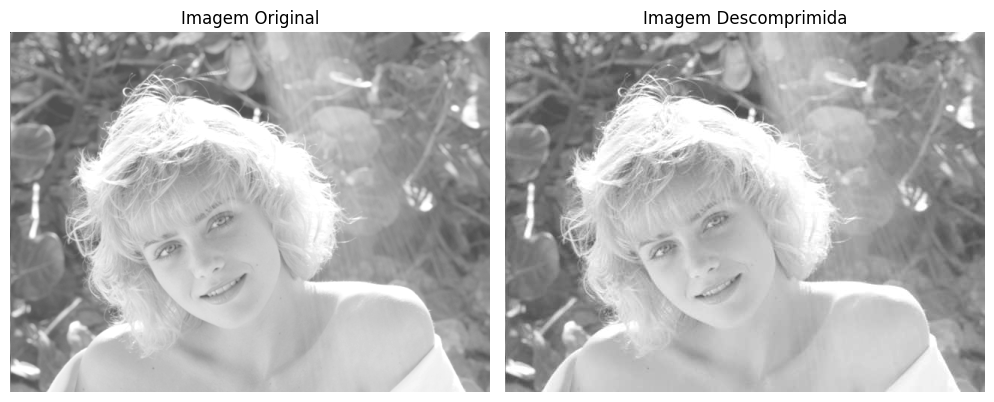

In [150]:
# Descompressão
img_path = 'images/compressed/marcie_comprimida_jpeg_dct.huff'
img_rec = dct_jpeg_descompression(img_path)

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Descomprimida
plt.subplot(1, 3, 2)
plt.imshow(img_rec, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Descomprimida')
plt.axis('off')

plt.tight_layout()
plt.show()

In [151]:
# Métricas de Erro
rmse = rmse_metric(img, img_rec)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, img_rec)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 2.7407663258259887
Métrica PSNR: 39.37336341398097 dB


## Funções de compressão e descompressão usando a transformada DFT

Ainda falta terminar a descrição e corrigir o código

---

- Avaliação

    Três métricas quantitativas são calculadas para medir a diferença entre a imagem original e a reconstruída:

    1. RMSE `(rmse_metric(img, IDFT_REAL))`: Erro quadrático médio.
    2. PSNR `(cv2.PSNR(img, IDFT_REAL))`: Relação sinal-ruído de pico (em dB).
    3. Taxa de compressão `Tamanho Original / Tamanho comprimido`

In [152]:
def dft_jpeg_compression(img, file_name, step=8):
    
    img = img.astype(float)             
    img = img - 128                     # Centraliza os valores da imagem em torno de 0

    # Matriz de Quantização
    QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                    [12, 12, 14, 19, 26, 58, 60, 55],
                    [14, 13, 16, 24, 40, 57, 69, 56],
                    [14, 17, 22, 29, 51, 87, 80, 62],
                    [18, 22, 37, 56, 68, 109, 103, 77],
                    [24, 35, 55, 64, 81, 104, 113, 92],
                    [49, 64, 78, 87, 103, 121, 120, 101],
                    [72, 92, 95, 98, 112, 100, 103, 99]])

    # 1. Realiza Transformada DCT
    DFT_REAL, DFT_IM, magnitude = dft_transform(img)
    # 2. Quantização
    magnitude_quant, phase = quantizacao_DFT(DFT_REAL, DFT_IM, QM)
    # 3. Codificação Huffman (Codificação por Entropia)
    codigos_huffman_mag, dados_codificados_mag = huffman_encode(magnitude_quant)
    codigos_huffman_phase, dados_codificados_phase = huffman_encode(phase)

    # Salvando dados comprimidos:
    dados_comprimidos = {
        'dados_codificados_mag': dados_codificados_mag,
        'dados_codificados_phase': dados_codificados_phase,
        'codigos_huffman_mag': codigos_huffman_mag,
        'codigos_huffman_phase': codigos_huffman_phase,
        'shape_mag': magnitude_quant.shape,
        'shape_phase': phase.shape,
    }
    path = os.path.join('images/compressed', file_name)
    with open(path, 'wb') as f:
        pickle.dump(dados_comprimidos, f)
    print(f"Dados comprimidos salvos em {path}")

    # Desfaz o deslocamento de 128 da imagem
    img = img + 128


def dft_jpeg_descompression(img_path, step=8):

    # Matriz de Quantização
    QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                    [12, 12, 14, 19, 26, 58, 60, 55],
                    [14, 13, 16, 24, 40, 57, 69, 56],
                    [14, 17, 22, 29, 51, 87, 80, 62],
                    [18, 22, 37, 56, 68, 109, 103, 77],
                    [24, 35, 55, 64, 81, 104, 113, 92],
                    [49, 64, 78, 87, 103, 121, 120, 101],
                    [72, 92, 95, 98, 112, 100, 103, 99]])

    # Carregar os dados comprimidos
    with open(img_path, 'rb') as f:
        dados_comprimidos = pickle.load(f)

    # Coeficientes quantizados e fase recuperados
    magnitude_rec, phase_rec = huffman_decode_dft(dados_comprimidos)

    # Desquantização
    original_dft_real, original_dft_im = desquantizacao_DFT(magnitude_rec, phase_rec, QM)

    # Realiza a Transformada Inversa (IDFT)
    img_rec, dft_im = idft_transform(original_dft_real, original_dft_im)

    return img_rec

In [153]:
# Compressão
img = imagem.copy()
img = img.astype(float)

file_name = 'marcie_comprimida_jpeg_dft.huff'
dft_jpeg_compression(img, file_name)

Dados comprimidos salvos em images/compressed\marcie_comprimida_jpeg_dft.huff


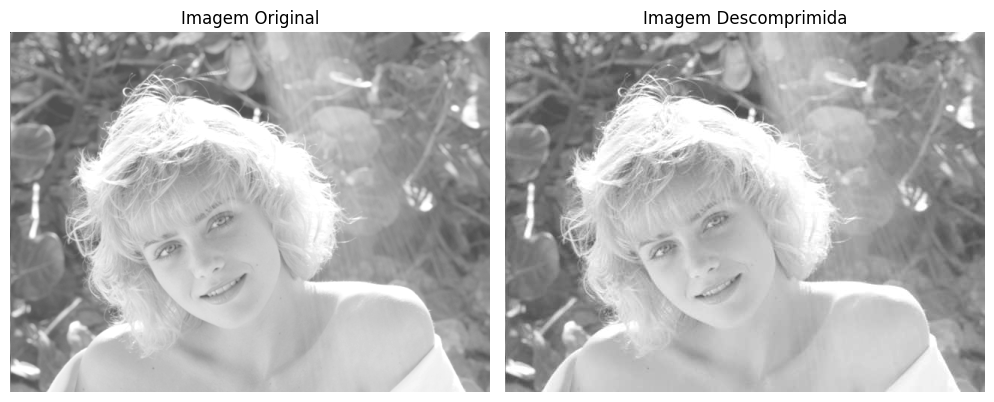

In [154]:
# Descompressão
img_path = 'images/compressed/marcie_comprimida_jpeg_dft.huff'
# img_rec = dft_jpeg_descompression(img_path) Esta em LOOP

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Descomprimida
plt.subplot(1, 3, 2)
plt.imshow(img_rec, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Descomprimida')
plt.axis('off')

plt.tight_layout()
plt.show()